In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.transforms import Transform
from matplotlib.patches import Circle
from matplotlib import cm,colors
from astropy.io import fits
import statistics as stat
from scipy.optimize import curve_fit
from scipy import stats
import scipy
import pickle
import yaml

from functions import mkProfile, T_convert
from donutlib.decamutil import decaminfo
dinfo = decaminfo()



In [2]:
hduY1 = fits.open("/u/ec/roodman/kipacdisk/PIFF/psf_y1a1-v13.fits")
hduY1.info()

hduY3 = fits.open("/u/ec/roodman/kipacdisk/PIFF/psf_y3a1-v29.fits")
hduY3.info()

d = yaml.safe_load(open("/nfs/slac/g/ki/ki06/roodman/Pixmappy/Y6A1_ASTROMETRY/astrorings4.yaml",'r'))

pickle_file = "/u/ec/roodman/kipacdisk/PIFF/pixmappy_pix_area.pkl"
[fov_x_in,fov_y_in,pix_area_in] = pickle.load(open(pickle_file, "rb"))

Filename: /u/ec/roodman/kipacdisk/PIFF/psf_y1a1-v13.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     40   14468770R x 16C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, 1A, I]   
Filename: /u/ec/roodman/kipacdisk/PIFF/psf_y3a1-v29.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     42   56707987R x 17C   [D, D, D, D, D, D, D, D, D, D, D, D, D, J, I, 1A, I]   


In [3]:
# get the Y1 datatable
tableY1 = hduY1[1].data
print(tableY1.columns)

# get the Y3 datatable
tableY3 = hduY3[1].data
print(tableY3.columns)

print(dinfo.infoDict.keys())

print(pix_area_in.keys())

ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'x'; format = 'D'
    name = 'y'; format = 'D'
    name = 'e1'; format = 'D'
    name = 'e2'; format = 'D'
    name = 'size'; format = 'D'
    name = 'psf_e1'; format = 'D'
    name = 'psf_e2'; format = 'D'
    name = 'psf_size'; format = 'D'
    name = 'exp'; format = 'D'
    name = 'ccd'; format = 'D'
    name = 'fov_x'; format = 'D'
    name = 'fov_y'; format = 'D'
    name = 'filter'; format = '1A'
    name = 'tiling'; format = 'I'
)
ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'x'; format = 'D'
    name = 'y'; format = 'D'
    name = 'obs_e1'; format = 'D'
    name = 'obs_e2'; format = 'D'
    name = 'obs_T'; format = 'D'
    name = 'piff_e1'; format = 'D'
    name = 'piff_e2'; format = 'D'
    name = 'piff_T'; format = 'D'
    name = 'mag'; format = 'D'
    name = 'fov_x'; format = 'D'
    name = 'fov_y'; format = 'D'
    name = 'exp'; format = 'J'
    name = 'ccd'

In [4]:
# select just Y1 exposures in CCD=1 (S29 in Engineering drawings)
ccd1_Y1 = tableY1['ccd']==1
S29_Y1 = tableY1[(ccd1_Y1)]

# select just Y3 exposures in CCD=1 (S29 in Engineering drawings)
ccd1_Y3 = tableY3['ccd']==1
S29_Y3 = tableY3[(ccd1_Y3)]


In [5]:
# Select stars in bands r,i,z
iS29_Y1_rband = (S29_Y1['filter']=='r')
iS29_Y1_iband = (S29_Y1['filter']=='i')
iS29_Y1_zband = (S29_Y1['filter']=='z')
print('Y1 Stars in r,i,z bands ',len(S29_Y1[iS29_Y1_rband]),len(S29_Y1[iS29_Y1_iband]),len(S29_Y1[iS29_Y1_zband]))

iS29_Y3_rband = (S29_Y3['band']=='r')
iS29_Y3_iband = (S29_Y3['band']=='i')
iS29_Y3_zband = (S29_Y3['band']=='z')
print('Y3 Stars in r,i,z bands ',len(S29_Y3[iS29_Y3_rband]),len(S29_Y3[iS29_Y3_iband]),len(S29_Y3[iS29_Y3_zband]))

Y1 Stars in r,i,z bands  59573 61755 49374
Y3 Stars in r,i,z bands  169800 218435 226797


In [6]:
# select the center of the ring values for CCD S29 aka 1  
tableS29 = d['S29']

print(tableS29['XCenter'], tableS29['YCenter'])
print(tableS29['Values'])

1004.08 3196.22
[-0.0006923158367711987, -0.0003751539329385155, 0.004212166319500803, 0.002311531056503301, 0.0013739930809331087, 0.00703460519601736, 0.006982420205470284, 0.004720490913619885, 0.001230870125537895, 0.00021627731384037075, -8.123471450718312e-05, 0.0006372959395296643, -0.001354305187341575, -0.002339988780724051, -0.0026615616684482033, -0.001075401439115244, -0.0003697780786142228, -0.0014366503230900075, -0.0019445298941826534, -0.003701493870433937, -0.004468793347198359, -0.006487716765076518, -0.006835490512336891, -0.0061774663266293255, -0.007121261846192672, -0.007252307428693674, -0.004662728319484365, -0.005457512263868808, -0.006234355488086586, -0.008215954339318546, -0.00800383859760501, -0.008446624146659632, -0.00877785897046024, -0.007261086788715975, -0.005233328425872888, -0.003597145758725369, -0.0014556614687266454, -0.0006200508235224656, 0.0004012547176471293, 0.00037477983794070857, 0.0011578858469132028, 0.0014208637767173565, 0.001703490369

In [7]:
## Converting the position of the center of the tree rings from pixel space to fov space
# units is 0.263 arcsec/pixel and 0.015 mm/pixel
factor = 0.263 / 0.015

# ix,iy are pixel number (probably starts at 1 not 0)
# getPosition returns the focal plane x,y position in [mm]
fov_x_treecenter, fov_y_treecenter = dinfo.getPosition("S29", 1004.08, 3196.22)

# now we calculate the x,y position in arcsec
fov_x_treecenter = fov_x_treecenter * factor
fov_y_treecenter = fov_y_treecenter * factor

# Calculate radius and deltaT

In [8]:
def T_convert(s):
    return 2 * s**2

In [9]:
def mkProfile(xarr,yarr,nx=100,xmin=0.,xmax=1.0,ymin=0.,ymax=1.0,retPlot=True):
    dx = (xmax-xmin)/nx
    bins = np.arange(xmin,xmax+dx,dx)
    nbin = len(bins)-1
    #print(dx,bins,nbin)
    inrange = (yarr>=ymin) & (yarr<ymax)
    yinrange = yarr[inrange]
    xinrange = xarr[inrange]
    ind = np.digitize(xinrange,bins) - 1.   #np.digitize starts at bin=1
    xval = np.zeros(nbin)
    xerr = np.zeros(nbin)
    yval = np.zeros(nbin)
    yerr = np.zeros(nbin)
    for i in range(nbin):
        inbin = (ind==i)
        xinbin = xinrange[inbin]
        yinbin = yinrange[inbin]
        nentries = len(yinbin)
        xval[i] = 0.5*(bins[i+1]+bins[i])
        xerr[i] = 0.5*(bins[i+1]-bins[i])
        if nentries>0:
            yval[i] = np.mean(yinbin)
            yerr[i] = np.std(yinbin)/np.sqrt(nentries)
            #print(i,xval[i],xerr[i],yval[i],yerr[i])
    if retPlot:
        profile = plt.errorbar(xval,yval,xerr=xerr,yerr=yerr)
        return profile
    else:
        return xval,yval,xerr,yerr



In [10]:
# for Y1, find distance from tree ring center to star
# also convert from size,psf_size to T, where T=Ixx+Iyy using T_convert function
# 0.263 is the pixel scale in arcsec/pixel, so radius is in units of [pixel] and deltaT is in units of [pixel^2]

radius_S29_Y1 = np.sqrt( (S29_Y1['fov_y'] - fov_y_treecenter)**2 + (S29_Y1['fov_x'] - fov_x_treecenter)**2 ) / 0.263
deltaT_S29_Y1 = (T_convert(S29_Y1['size'])-T_convert(S29_Y1['psf_size'])) / 0.263**2
fov_x_S29_Y1 = S29_Y1['fov_x']/0.263
fov_y_S29_Y1 = S29_Y1['fov_y']/0.263

In [11]:
# for Y3, find distance from tree ring center to star
# also calculate deltaT where T=Ixx+Iyy using T_convert function
# 0.263 is the pixel scale in arcsec/pixel, so radius is in units of [pixel] and deltaT is in units of [pixel^2]

radius_S29_Y3 = np.sqrt( (S29_Y3['fov_y'] - fov_y_treecenter)**2 + (S29_Y3['fov_x'] - fov_x_treecenter)**2 ) / 0.263
deltaT_S29_Y3 = (S29_Y3['obs_T']-S29_Y3['piff_T']) / 0.263**2
fov_x_Y329 = S29_Y3['fov_x']/0.263
fov_y_Y329 = S29_Y3['fov_y']/0.263

In [12]:
## Values for fov_x, fov_y, and pix_area from CCD29 in the pickle file.
iCCD = 1
ixs = fov_x_in[iCCD]
iys = fov_y_in[iCCD]
ipa = pix_area_in[iCCD]
iny,inx = ipa.shape
ixlist = []
iylist = []
ipalist = []
for iy in range(iny):
    for ix in range(inx):
        ipalist.append(ipa[iy,ix])
        ixlist.append( (ixs[iy,ix]+ixs[iy,ix+1])/2. )
        iylist.append( (iys[iy,ix]+iys[iy+1,ix])/2. )
        
ixlist_array = np.array(ixlist)
iylist_array = np.array(iylist)
ipalist_array = np.array(ipalist)

In [13]:
# pixel size
radius_pixmap = np.sqrt( (iylist_array - fov_y_treecenter)**2 + (ixlist_array - fov_x_treecenter)**2 ) / 0.263
pixelarea_pixmap = ipalist_array / 0.263**2
fov_x_pixmap = iylist_array/0.263
fov_y_pixmap = ixlist_array/0.263


# i band 

<IPython.core.display.Javascript object>


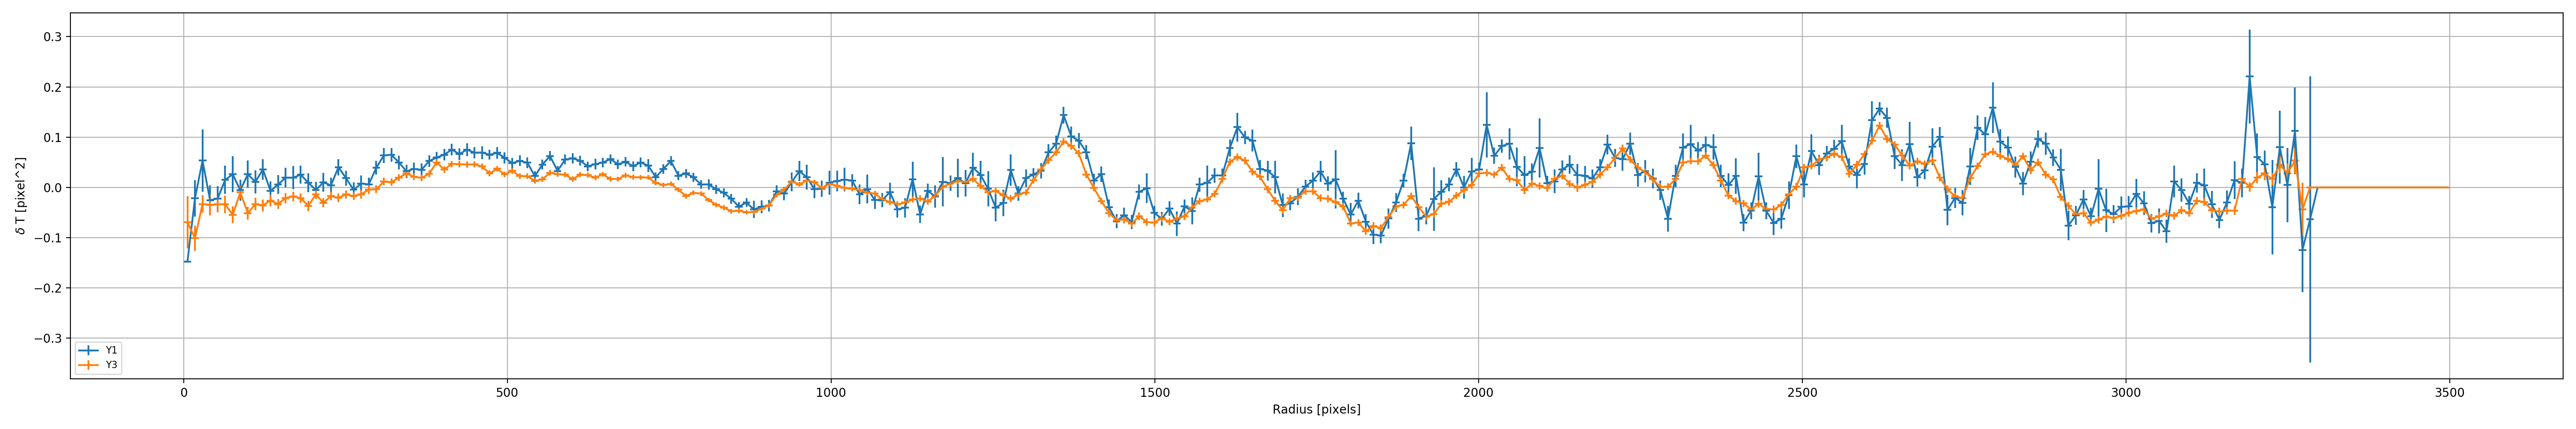

In [14]:
f, ax = plt.subplots(figsize=(30,5))

nbins = 300
xmax = 3500.

r = radius_S29_Y1[iS29_Y1_iband]
dT = deltaT_S29_Y1[iS29_Y1_iband]
ixvalY1, iyvalY1, ixerrY1, iyerrY1 = mkProfile(r, dT, nx=nbins, xmin=0,xmax=xmax, ymin=np.min(dT),ymax=np.max(dT), retPlot=False)
ax.errorbar(ixvalY1, iyvalY1, xerr=ixerrY1, yerr=iyerrY1,label = 'Y1')

r = radius_S29_Y3[iS29_Y3_iband]
dT = deltaT_S29_Y3[iS29_Y3_iband]
ixvalY3, iyvalY3, ixerrY3, iyerrY3 = mkProfile(r, dT, nx=nbins, xmin=0,xmax=xmax, ymin=np.min(dT),ymax=np.max(dT), retPlot=False)
ax.errorbar(ixvalY3, iyvalY3, xerr=ixerrY3, yerr=iyerrY3,label = 'Y3')
    
ax.legend(loc=3, fontsize=8)
ax.grid()
ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('$\delta$ T [pixel^2]')
f.tight_layout()

# pixel size  vs radius

<IPython.core.display.Javascript object>


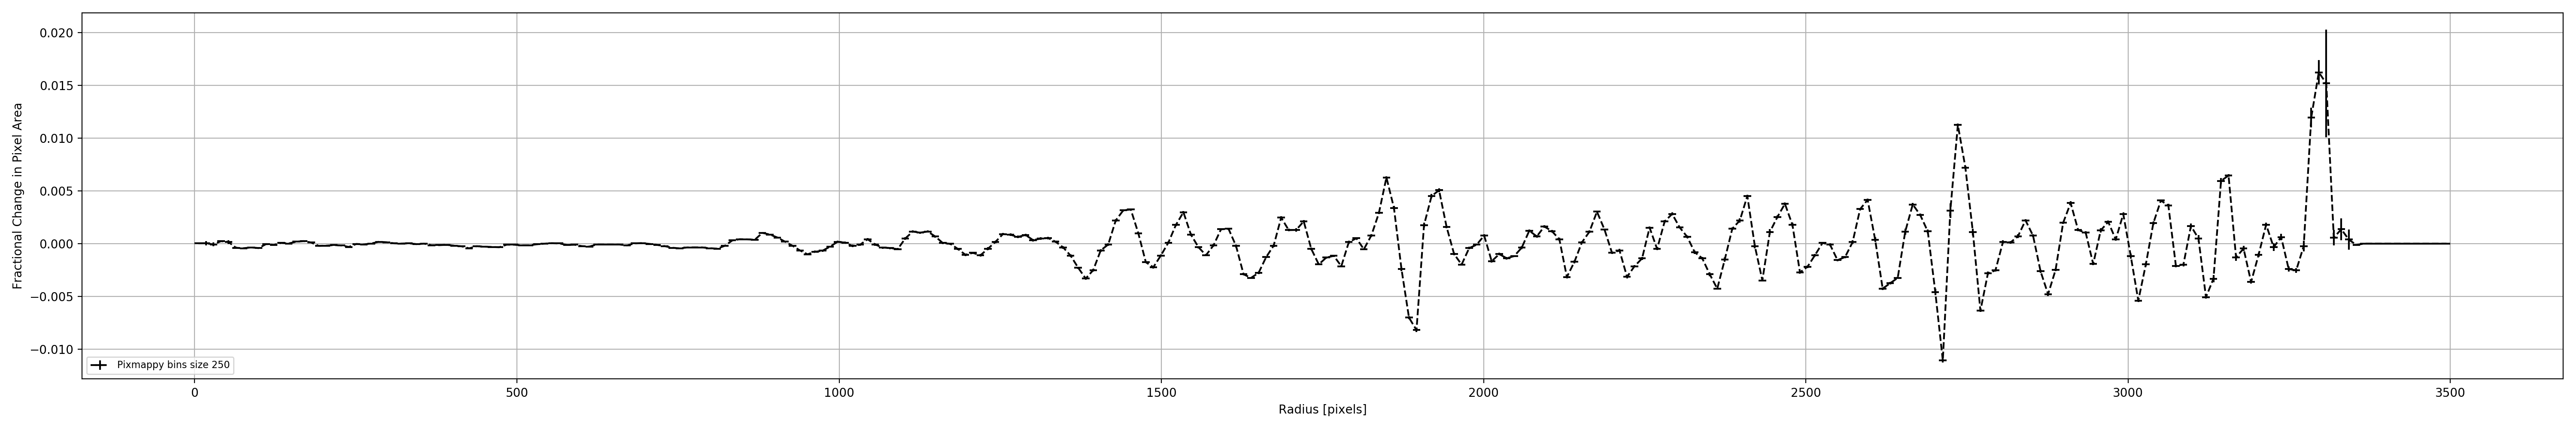

In [15]:
# plot pixelsize residual vs. radius

delta_pixelsize = (pixelarea_pixmap - np.mean(pixelarea_pixmap))/pixelarea_pixmap
xpval2, ypval2, xperr2, yperr2 = mkProfile(radius_pixmap, delta_pixelsize, nx=300, xmin=0., xmax=3500.,ymin=np.min(delta_pixelsize),ymax=np.max(delta_pixelsize),retPlot=False)

f,ax = plt.subplots(figsize=(30,5))
ax.errorbar(xpval2, ypval2, xerr=xperr2, yerr=yperr2, color='k', ls='--', label = 'Pixmappy bins size 250')

ax.legend(loc=3, fontsize=8)
ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('Fractional Change in Pixel Area')
ax.grid(True)
f.tight_layout()


<IPython.core.display.Javascript object>


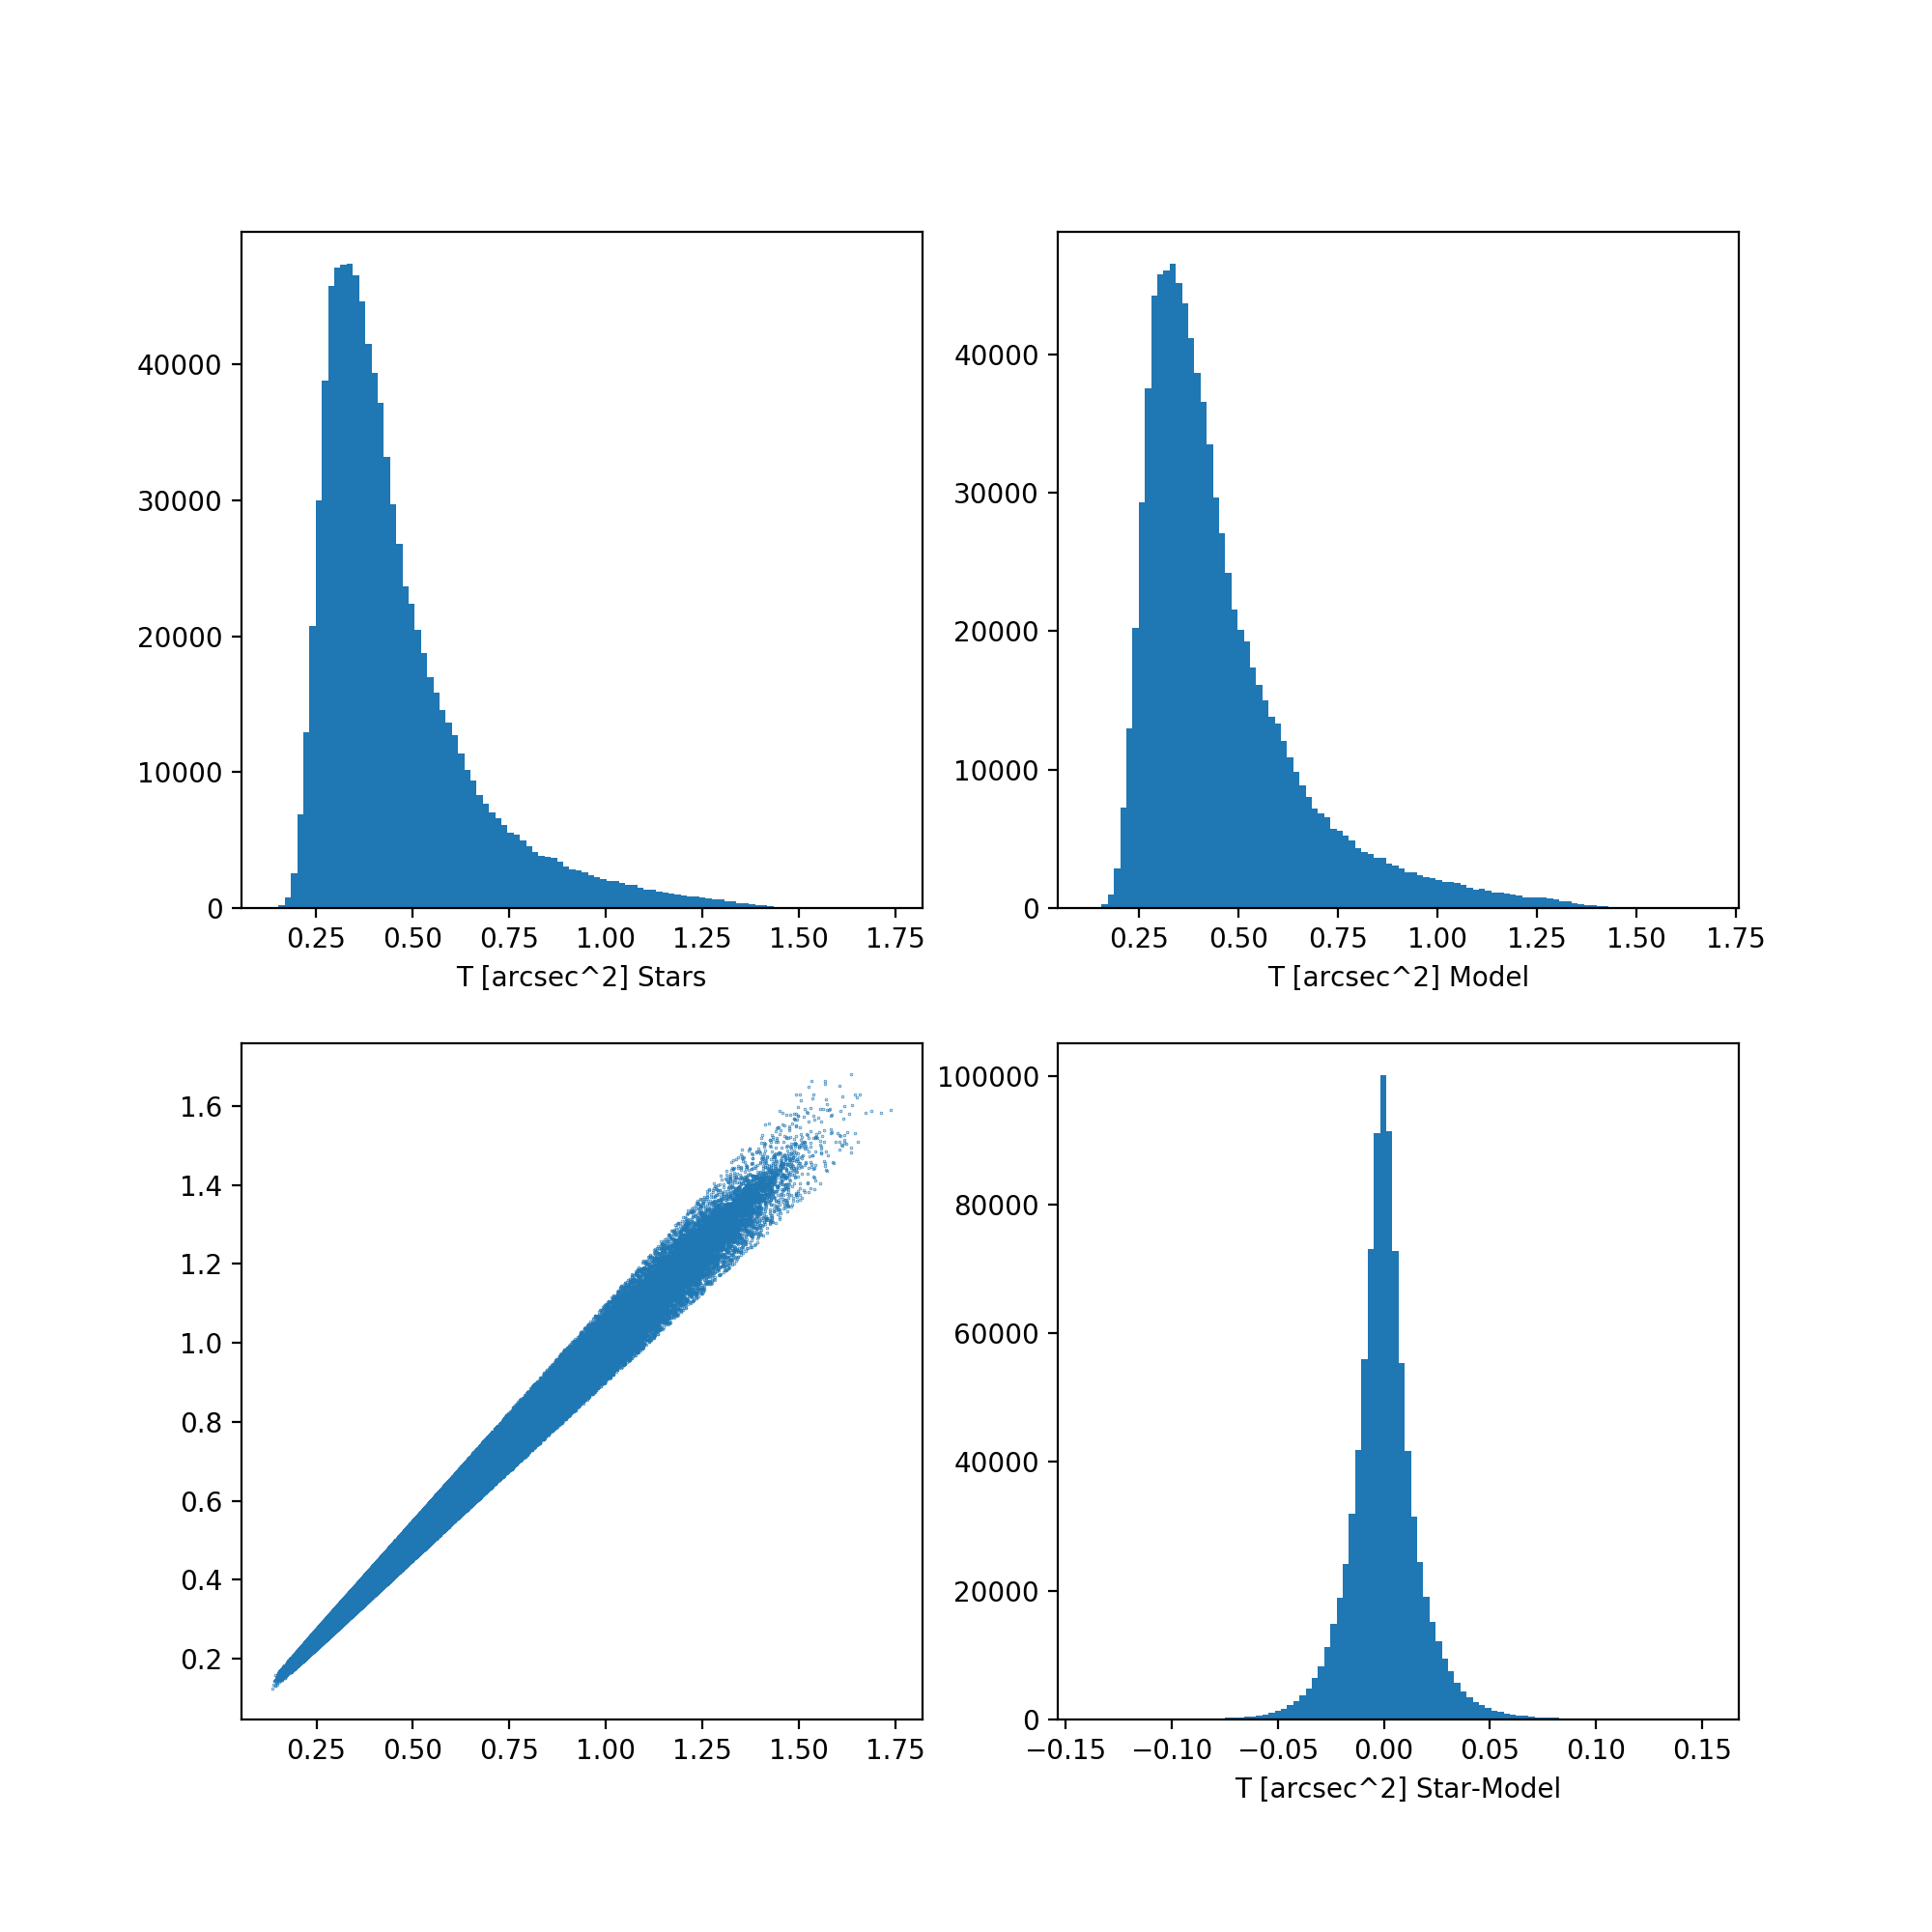

Text(0.5, 0, 'T [arcsec^2] Star-Model')

In [16]:
# other plots
f,axf = plt.subplots(2,2,figsize=(10,10))
ax = axf.flatten()

h = ax[0].hist(S29_Y3['obs_T'],bins=100)
ax[0].set_xlabel('T [arcsec^2] Stars')
h = ax[1].hist(S29_Y3['piff_T'],bins=100)
ax[1].set_xlabel('T [arcsec^2] Model')

h = ax[2].scatter(S29_Y3['obs_T'],S29_Y3['piff_T'],s=0.05)
h = ax[3].hist(S29_Y3['obs_T']-S29_Y3['piff_T'],bins=100)
ax[3].set_xlabel('T [arcsec^2] Star-Model')



In [17]:

S29_Y3_iband = S29_Y3[iS29_Y3_iband]
x,y,ex,ey = mkProfile(S29_Y3_iband['exp'],S29_Y3_iband['obs_T'],nx=400000, xmin=200000.0-0.5,xmax=600000.0-0.5,ymin=0.0,ymax=4.0,retPlot=False)

<IPython.core.display.Javascript object>


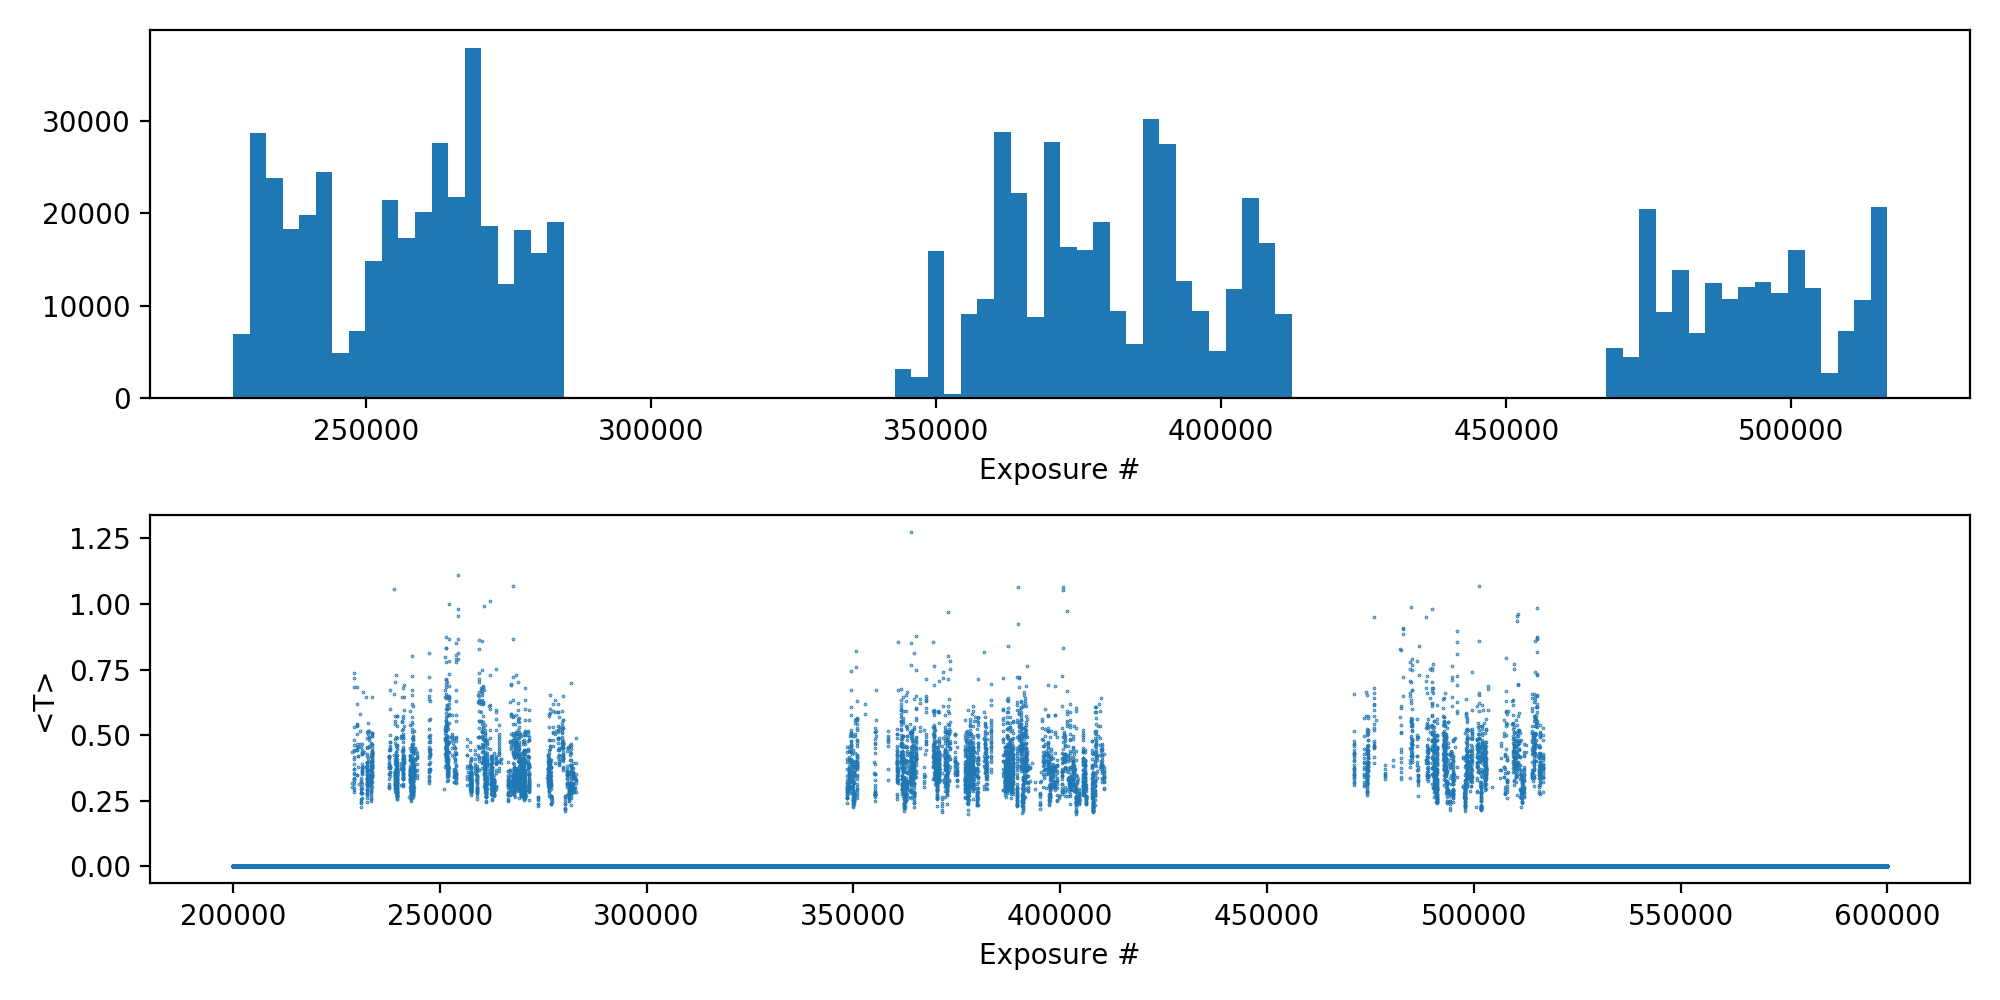

In [18]:
# other plots
f,axf = plt.subplots(2,1,figsize=(10,5))
ax = axf.flatten()

h = ax[0].hist(S29_Y3['exp'],bins=100)
ax[0].set_xlabel('Exposure #')
h = ax[1].scatter(x,y,s=0.1)
ax[1].set_xlabel('Exposure #')
ax[1].set_ylabel('<T>')

f.tight_layout()






In [19]:
des_fwhm = pd.read_pickle('des_fwhm.pkl')
print(des_fwhm)

         expid      fwhm  qc_fwhm
24746   179838  1.279838      NaN
24747   179839  1.363566      NaN
24748   179840  1.368055      NaN
24749   179841  1.231741      NaN
24750   179842  1.310569      NaN
...        ...       ...      ...
249475  540912  2.070894     2.10
249476  540913  2.002053     2.03
249477  540914  1.791285     1.79
249480  540917  2.200123     2.33
249481  540918  2.240463     2.39

[222594 rows x 3 columns]


In [20]:
ix = x.astype(int)
data_dict = {'expid':ix,'meanT':y}
des_T = pd.DataFrame(data_dict)
print(des_T)

         expid  meanT
0       200000    0.0
1       200001    0.0
2       200002    0.0
3       200003    0.0
4       200004    0.0
...        ...    ...
399995  599995    0.0
399996  599996    0.0
399997  599997    0.0
399998  599998    0.0
399999  599999    0.0

[400000 rows x 2 columns]


In [21]:
des_fwhmT = des_T.merge(des_fwhm,on='expid')
ok = (des_fwhmT.meanT>0.) & (des_fwhmT.fwhm>0.)
des_fwhmT = des_fwhmT[ok]
print(des_fwhmT)

         expid     meanT      fwhm  qc_fwhm
16819   228724  0.434234  1.033544      NaN
16823   228728  0.316621  0.815394      NaN
16825   228730  0.302692  0.811400      NaN
17076   229296  0.315584  0.836271     0.85
17079   229299  0.326476  0.875039     0.88
...        ...       ...       ...      ...
193568  516779  0.406121  0.964463     0.93
193570  516781  0.420119  1.007792     0.97
193579  516790  0.385628  0.949908     0.92
193583  516794  0.373787  0.980211     0.93
193585  516796  0.373189  0.948262     0.90

[7179 rows x 4 columns]


<IPython.core.display.Javascript object>


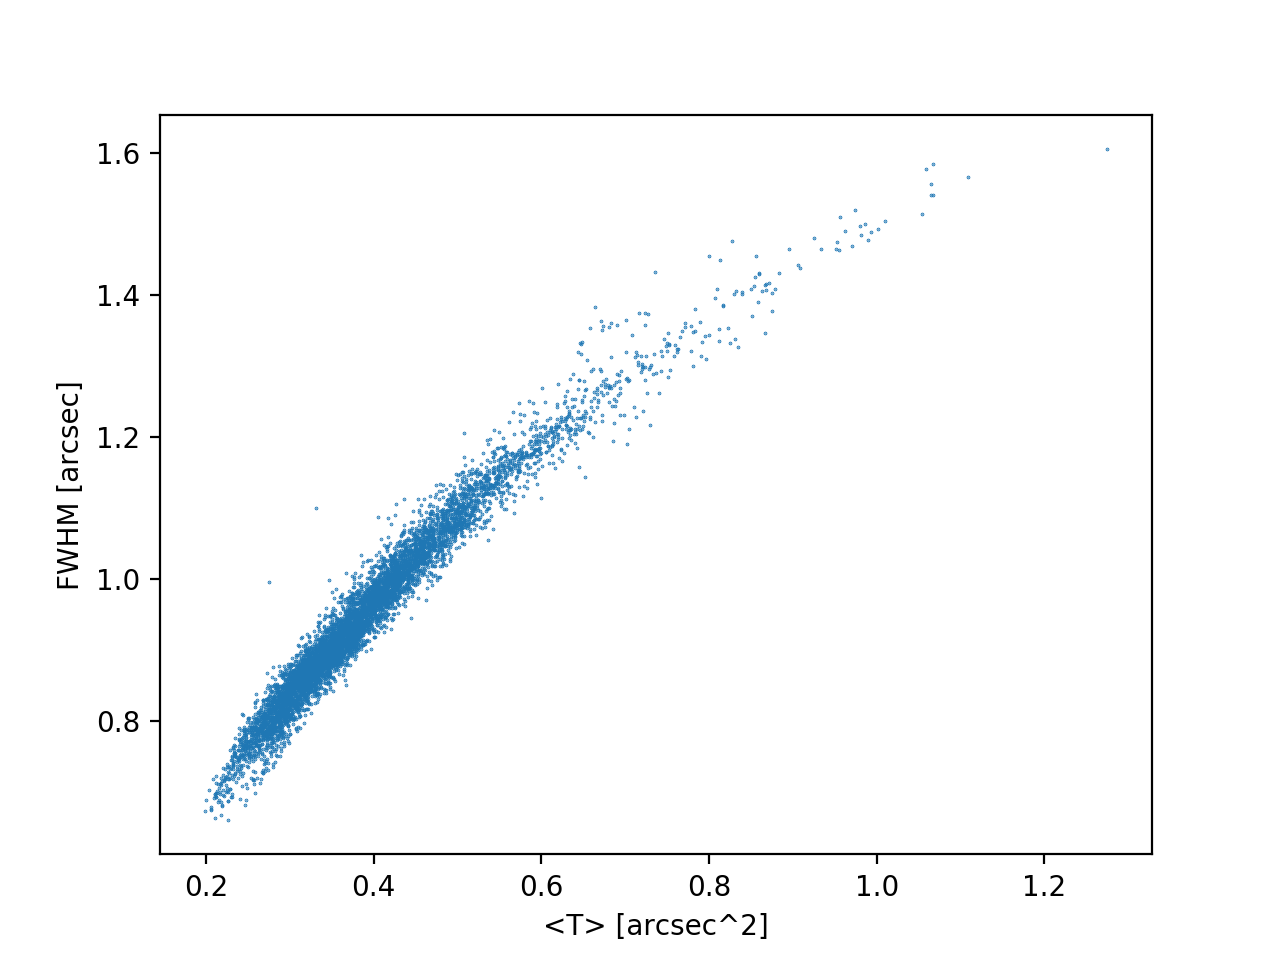

Text(0, 0.5, 'FWHM [arcsec]')

In [22]:
f,ax = plt.subplots(1,1)
ax.scatter(des_fwhmT.meanT,des_fwhmT.fwhm,s=0.1)
ax.set_xlabel('<T> [arcsec^2]')
ax.set_ylabel('FWHM [arcsec]')

# Moment definitions

$$ I_{xx} = \frac{ \sum_i I_i * x^2_i * w_i }{\sum_i I_i * w_i} $$

$$ I_{yy} = \frac{ \sum_i I_i * y^2_i * w_i }{\sum_i I_i * w_i} $$

$$ I_{xy} = \frac{ \sum_i I_i * x_i * y_i *  w_i }{\sum_i I_i * w_i} $$

$$ T = I_{xx} + I_{yy} $$

$$ e_1 =  I_{xx} - I_{yy} $$

$$ e_2 =  2 * I_{xy} $$

# Conversion between T and $\sigma$

for a 2-d Gaussian $ I(x,y) \sim \exp{-\frac{x^2+y^2}{2\sigma^2}}$ , $I_{xx} = \sigma^2$, so $T = 2\sigma^2$ 

then use that ${\rm FWHM} = 2\sqrt{2\log{2}} \sigma$

to get $ {\rm FWHM} = 2.355 \sqrt{T/2} $


<IPython.core.display.Javascript object>


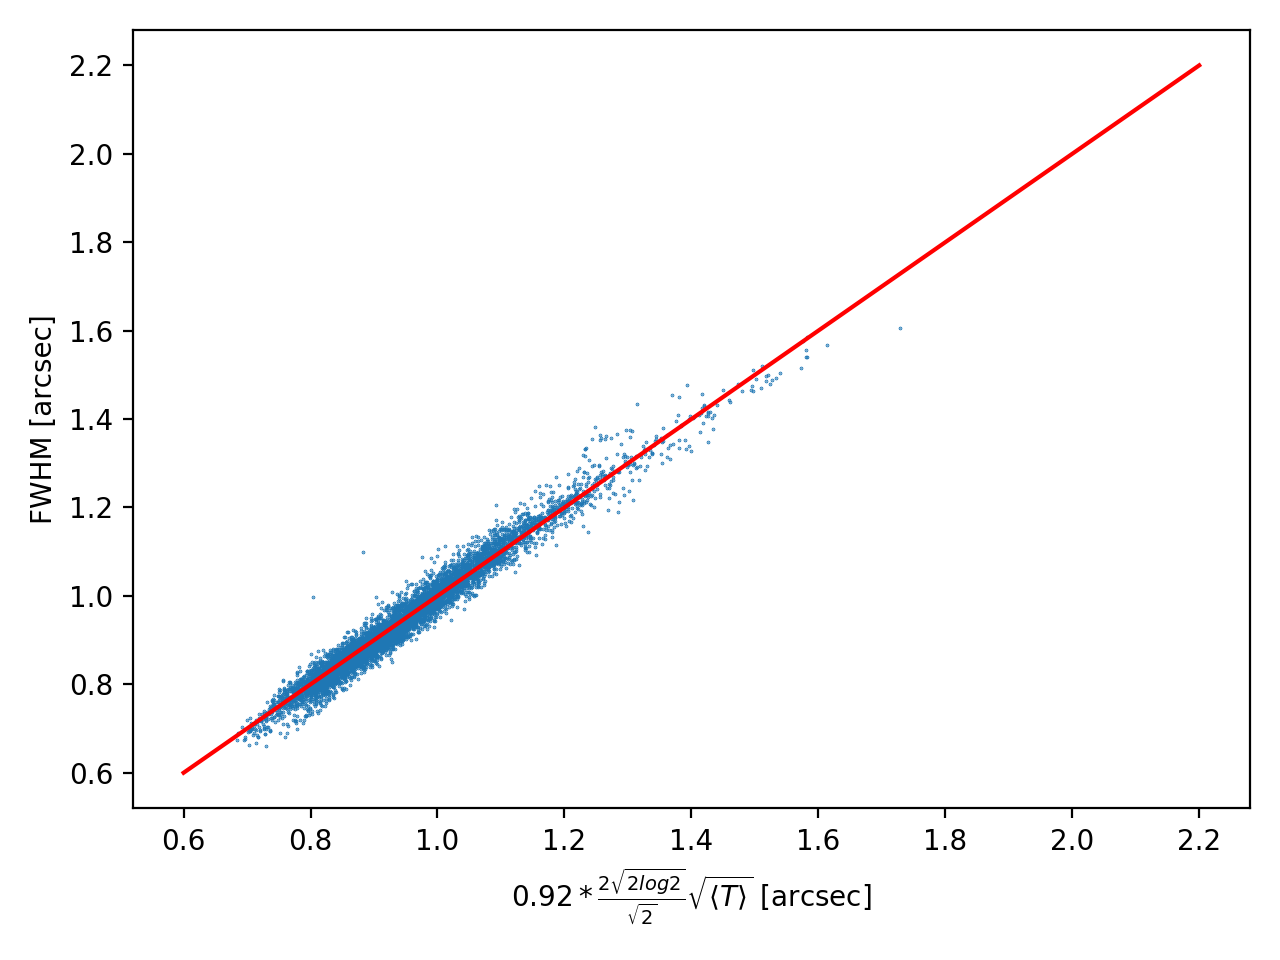

In [23]:
f,ax = plt.subplots(1,1)
fudge = 0.92
factor = fudge*2.*np.sqrt(2.*np.log(2.))/np.sqrt(2.)
ax.scatter(factor*np.sqrt(des_fwhmT.meanT),des_fwhmT.fwhm,s=0.1)
ax.set_xlabel(r"$0.92 * \frac{2\sqrt{2log2}}{\sqrt{2}} \sqrt{\langle T \rangle}$ [arcsec]")
ax.set_ylabel('FWHM [arcsec]')

ax.plot([0.6,2.2], [0.6,2.2], 'k-', color = 'r')

f.tight_layout()
